In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Exploration

In [2]:
import pandas as pd
import random
p = 0.2  # 1% of the lines
# keep the header, then take only 1% of lines
# if random from [0,1] interval is greater than 0.01 the row will be skipped
df = pd.read_csv(
         "train_2.csv.zip",
         header=0, 
         skiprows=lambda i: i>0 and random.random() > p
)
df = df.sample(frac=1).reset_index(drop=True).fillna(0)
Page = df.Page
agent = Page.apply(lambda x: x.split("_")[-1])
access = Page.apply(lambda x: x.split("_")[-2])
wikiproject = Page.apply(lambda x: x.split("_")[-3])
page_name = Page.apply(lambda x: "_".join(x.split("_")[:-3]))
df.drop(columns=["Page"], inplace=True)

In [3]:
df[['2017-09-09', '2017-09-10']]

,2017-09-09,2017-09-10
0,45.0,37.0
1,7942.0,7531.0
2,620.0,5064.0
3,17.0,8.0
4,3547.0,0.0
...,...,...
29055,1.0,1.0
29056,109.0,141.0
29057,8.0,6.0
29058,62.0,68.0


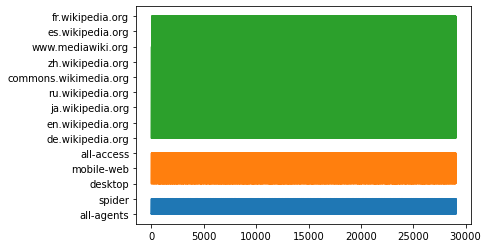

In [4]:
f, ax = plt.subplots()
ax.plot(agent)
ax.plot(access)
ax.plot(wikiproject)

In [5]:
tmp = df.loc[agent=="spider"].head().T.reset_index(drop=True)
tmp.columns = Page.head()
tmp

Page,Andrei_Igorewitsch_Melnitschenko_de.wikipedia.org_desktop_all-agents,Liev_Schreiber_en.wikipedia.org_mobile-web_all-agents,築山殿_ja.wikipedia.org_mobile-web_all-agents,Земноводные_ru.wikipedia.org_all-access_spider,J._Cole_en.wikipedia.org_all-access_all-agents
0,19.0,5.0,22.0,10.0,19.0
1,18.0,7.0,39.0,2.0,19.0
2,10.0,7.0,19.0,4.0,18.0
3,16.0,4.0,19.0,5.0,8.0
4,6.0,4.0,20.0,1.0,5.0
...,...,...,...,...,...
798,15.0,5.0,20.0,6.0,25.0
799,16.0,9.0,19.0,7.0,10.0
800,5.0,2.0,25.0,4.0,18.0
801,17.0,7.0,26.0,11.0,51.0


/home/cprat/anaconda3/envs/tf/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 31689 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cprat/anaconda3/envs/tf/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 23665 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cprat/anaconda3/envs/tf/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 27583 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cprat/anaconda3/envs/tf/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 31689 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/cprat/anaconda3/envs/tf/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 23665 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/cprat/anaconda3/envs/tf/lib/python3.8/site-packa

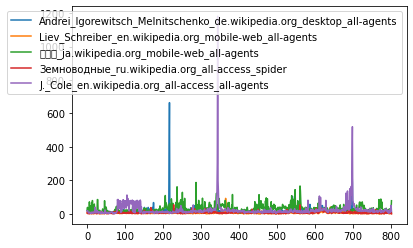

In [6]:
f, ax = plt.subplots()
line = ax.plot(df.loc[agent=="spider"].head().T.reset_index(drop=True))
ax.legend(line, Page.head())
plt.show()

### SMAPE

In [7]:
def smape_np(A, F):
    return 100/A.size * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F) + np.finfo(float).eps))

In [8]:
def last_repeated_estimator(ts_prev):
    """ ts_prev : matrix (m, Ts) """
    return np.tile(ts_prev[:,-1].reshape(-1,1), (1,62))

In [9]:
Dnum = df.fillna(0).values[:,5:]

In [10]:
smape_np(np.zeros_like(Dnum), Dnum)

185.7250145322011

In [11]:
Mmean = np.tile(np.mean(Dnum, 1).reshape(-1,1) , (1,Dnum.shape[1]))
smape_np(Mmean, Dnum)

71.90089724769227

### Autocorrelation

In [12]:
def estimated_autocorrelation(x):
    """
    http://stackoverflow.com/q/14297012/190597
    http://en.wikipedia.org/wiki/Autocorrelation#Estimation
    """
    n = len(x)
    variance = x.var()
    x = x-x.mean()
    r = np.correlate(x, x, mode = 'full')[-n:]
    assert np.allclose(r, np.array([(x[:n-k]*x[-(n-k):]).sum() for k in range(n)]))
    result = r/(variance*(np.arange(n, 0, -1)))
    return result

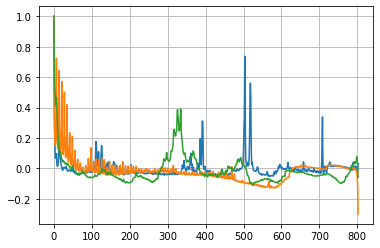

In [13]:
df_allagent = df.loc[agent=="all-agents"]



f, ax = plt.subplots()
ax.plot(estimated_autocorrelation(df_allagent.iloc[0,:].values))
#ax.plot(estimated_autocorrelation(df_allagent.iloc[1,:].values))
ax.plot(estimated_autocorrelation(df_allagent.iloc[2,:].values))
ax.plot(estimated_autocorrelation(df_allagent.iloc[3,:].values))
ax.scatter(365,0,s=10,c="r")
ax.grid()

##### dataset

In [14]:
Mtraffic = df.values

In [15]:
df_allagent.head()

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,45.0,159.0,200.0,63.0,35.0,157.0,39.0,24.0,31.0,22.0,...,40.0,36.0,81.0,116.0,106.0,77.0,86.0,70.0,45.0,37.0
1,2708.0,8810.0,4759.0,4804.0,6876.0,4940.0,4647.0,4840.0,4836.0,4825.0,...,5176.0,6061.0,7415.0,6594.0,5305.0,8509.0,24387.0,12411.0,7942.0,7531.0
2,104.0,81.0,64.0,143.0,115.0,117.0,107.0,114.0,103.0,164.0,...,377.0,767.0,1440.0,881.0,494.0,479.0,341.0,339.0,620.0,5064.0
4,7065.0,6567.0,6062.0,5370.0,5201.0,6310.0,6342.0,6483.0,6705.0,6283.0,...,4034.0,4047.0,4474.0,4193.0,4135.0,3932.0,4348.0,3736.0,3547.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,3.0,4.0,4.0,2.0,5.0,2.0,3.0,5.0,1.0


In [16]:
Mtraffic.shape

(29060, 803)

In [17]:
output_len = 62

Ltst = 1000
Ltr = Mtraffic.shape[0] - 2*Ltst
shift_start = 0

In [18]:
x_train, y_train = Mtraffic[:Ltr,shift_start:-output_len], Mtraffic[:Ltr,-output_len:]
x_valid, y_valid = Mtraffic[Ltr:Ltr+Ltst, shift_start:-output_len], Mtraffic[Ltr:Ltr+Ltst,-output_len:]
x_test, y_test = Mtraffic[Ltr+Ltst:, shift_start:-output_len], Mtraffic[Ltr+Ltst:,-output_len:]

In [19]:
np.max(x_train, axis=1)

array([  5807.,  62330.,  60039., ...,  37186.,  13237., 323269.])

In [20]:
x_train.shape, y_train.shape
x_train.shape, x_valid.shape, y_train.shape

((27060, 741), (1000, 741), (27060, 62))

### Models

In [21]:
import tensorflow as tf

In [22]:
def smape(A, F):
    return tf.reduce_mean(2 * tf.math.abs(F - A) / (tf.math.abs(A) + tf.math.abs(F) + 2e-16)) * 100 

In [23]:
#tensorboard callbacks
from datetime import datetime
datetime.now().strftime("%H-%M-%S")
def create_tb_cb(model_name):
    return tf.keras.callbacks.TensorBoard(log_dir="./logs/"+model_name+"-"+datetime.now().strftime("%H-%M-%S"))

###### repeat last value

In [24]:
def repeat_lv(X):
    return np.tile(X[:,-1].reshape(-1,1), reps=(1,output_len))

smape_np(repeat_lv(x_train), y_train), smape_np(repeat_lv(x_valid), y_valid), smape_np(repeat_lv(x_test), y_test)


(46.30148015271508, 45.82241756418929, 45.82065935771753)

In [25]:
repeat_lv(x_train)

array([[ 253.,  253.,  253., ...,  253.,  253.,  253.],
       [5397., 5397., 5397., ..., 5397., 5397., 5397.],
       [ 396.,  396.,  396., ...,  396.,  396.,  396.],
       ...,
       [  17.,   17.,   17., ...,   17.,   17.,   17.],
       [ 600.,  600.,  600., ...,  600.,  600.,  600.],
       [  11.,   11.,   11., ...,   11.,   11.,   11.]])

###### linear model

In [26]:
tf.keras.backend.clear_session()
tb_cb = create_tb_cb("linear")

In [27]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=output_len, 
                          kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0, l2=0))
])

In [28]:
model.compile(loss=smape, metrics=[smape], optimizer=tf.optimizers.Adam(learning_rate=1e-4))

In [29]:
def scheduler(epoch, lr):
    if epoch < 40:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
lr_cb = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [30]:
model.fit(x_train, y_train, epochs=100, batch_size=32 , 
          validation_data= (x_valid, y_valid), callbacks=[tb_cb, lr_cb])

Epoch 1/100
  1/846 [..............................] - ETA: 0s - loss: 151.1786 - smape: 151.1786WARNING:tensorflow:From /home/cprat/anaconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
846/846 [==============================] - 2s 2ms/step - loss: 126.9992 - smape: 126.9945 - val_loss: 122.6713 - val_smape: 121.9205
Epoch 2/100
846/846 [==============================] - 1s 2ms/step - loss: 120.6104 - smape: 120.6150 - val_loss: 118.8797 - val_smape: 118.0629
Epoch 3/100
846/846 [==============================] - 1s 2ms/step - loss: 117.3687 - smape: 117.3624 - val_loss: 116.5441 - val_smape: 115.7171
Epoch 4/100
846/846 [==============================] - 1s 2ms/step - loss: 114.7860 - smape: 114.7890 - val_loss: 114.3352 - val_smape: 113.5391
Epoch 5/100
846/846 [=================

846/846 [==============================] - 1s 2ms/step - loss: 47.2620 - smape: 47.2608 - val_loss: 48.2445 - val_smape: 47.9114
Epoch 55/100
846/846 [==============================] - 1s 1ms/step - loss: 46.9563 - smape: 46.9566 - val_loss: 48.0339 - val_smape: 47.7247
Epoch 56/100
846/846 [==============================] - 1s 1ms/step - loss: 46.6332 - smape: 46.6358 - val_loss: 47.7573 - val_smape: 47.4464
Epoch 57/100
846/846 [==============================] - 1s 1ms/step - loss: 46.3696 - smape: 46.3715 - val_loss: 47.3441 - val_smape: 47.0414
Epoch 58/100
846/846 [==============================] - 1s 1ms/step - loss: 46.1056 - smape: 46.1007 - val_loss: 47.4125 - val_smape: 47.1190
Epoch 59/100
846/846 [==============================] - 1s 2ms/step - loss: 45.9197 - smape: 45.9171 - val_loss: 47.1525 - val_smape: 46.8572
Epoch 60/100
846/846 [==============================] - 1s 1ms/step - loss: 45.6910 - smape: 45.6923 - val_loss: 46.9757 - val_smape: 46.6746
Epoch 61/100
846/84

In [31]:
model.optimizer.lr.numpy()
x_train.shape

(27060, 741)

In [32]:
def linear_estimator(x):
    return model.predict(x[:,-x_train.shape[1]:])

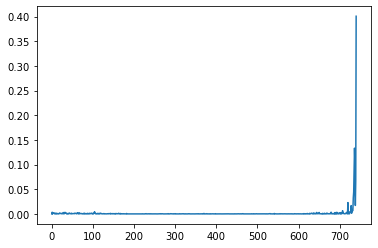

In [33]:
weights = model.get_layer("dense").get_weights()[0]

f,ax = plt.subplots()
ax.plot(np.abs(weights[:,0]))

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 62)                46004     
Total params: 46,004
Trainable params: 46,004
Non-trainable params: 0
_________________________________________________________________


###### Simple RNN

### reset memory

In [35]:
import gc

In [36]:
gc.collect()

4830

In [37]:
del df

### ouput

In [40]:
key = pd.read_csv("key_2.csv.zip").set_index("Page")

In [41]:
key["Visits"] = None
key.head()

,Id,Visits
Page,,
007_スペクター_ja.wikipedia.org_all-access_all-agents_2017-09-13,0b293039387a,None
007_スペクター_ja.wikipedia.org_all-access_all-agents_2017-09-14,7114389dd824,None
007_スペクター_ja.wikipedia.org_all-access_all-agents_2017-09-15,057b02ff1f09,None
007_スペクター_ja.wikipedia.org_all-access_all-agents_2017-09-16,bd2aca21caa3,None
007_スペクター_ja.wikipedia.org_all-access_all-agents_2017-09-17,c0effb42cdd5,None


In [42]:
def output_form(_df, _estimator=None):
    """ return a serie indexed by Page """
    out_date = pd.date_range(start="2017-09-13", end="2017-11-13", freq="1D").strftime("%Y-%m-%d").to_list()
    num_hist = _df.drop(columns="Page").fillna(0).values
    num_pred = _estimator(num_hist)
    ret = pd.DataFrame(num_pred, columns=out_date, index=_df["Page"]).stack().rename("Visits")
    ret.index = [ii[0]+"_"+ii[1] for ii in ret.index]
    return ret

chunk = pd.read_csv("train_2.csv.zip", nrows=10000)
Visits_pred = output_form(chunk, linear_estimator)

In [50]:
df_chunk = pd.read_csv("train_2.csv.zip", chunksize=10000)

for ii, chunk in enumerate(df_chunk):
    print("Prediction {}".format(ii))
    predictions = output_form(chunk, linear_estimator).astype(int)
    key.loc[predictions.index, "Visits"] = predictions.astype(int)

Prediction 0
Prediction 1
Prediction 2
Prediction 3
Prediction 4
Prediction 5
Prediction 6
Prediction 7
Prediction 8
Prediction 9
Prediction 10
Prediction 11
Prediction 12
Prediction 13
Prediction 14


In [53]:
key.to_csv("subm_linear.csv", encoding='utf-8', index=False)